In [2]:
import cv2
import pandas as pd
import numpy as np




#import segmentation_models_pytorch as smp
import time
import os
import json
import random

#import os
#os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
#os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnet50
import segmentation_models_pytorch as smp
import matplotlib.pyplot as plt
import matplotlib

from tqdm import tqdm
from IPython.display import clear_output 
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')
#print(f"Using GPU is CUDA:{os.environ['CUDA_VISIBLE_DEVICES']}")
print('Device:', device)
#print('Current cuda device:', torch.cuda.current_device())
#print('Count of using GPUs:', torch.cuda.device_count())

random_seed = 42
np.random.seed(random_seed)
random.seed(random_seed)

Device: cpu


In [3]:
# RLE 디코딩 함수
def rle_decode(mask_rle, shape):
    if mask_rle == -1:
        return np.zeros(shape, dtype=np.uint8)
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)

# RLE 인코딩 함수
def rle_encode(mask):
    if np.sum(mask) == 0:
        return '-1'
    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [4]:
class SatelliteDataset(Dataset):
    def __init__(self, csv_file, transform=None, infer=False):
        self.data = pd.read_csv(csv_file)
        self.transform = transform
        self.infer = infer
        print("full dataset size : ",len(self.data))
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        #img_path = self.data.iloc[idx, 1]    # default : ./train_img/TRAIN_0000.png
        img_path = "../data"+self.data.iloc[idx, 1][1:]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        img_id = self.data.iloc[idx, 0]

        return image, img_id

In [5]:
test_dataset = SatelliteDataset(csv_file='../data/test.csv', transform=None, infer=True)

full dataset size :  60640


In [6]:
csv_files = []
csv_files.append(pd.read_csv('../submit/b5_jhsstride_040_yjypost.csv'))  # CSV 파일 경로
csv_files.append(pd.read_csv('../submit/submit_deepsplit_post.csv'))

csv_files.append(pd.read_csv('../submit/b4_48batch_27000steps_040_yjypost.csv'))


csv_files.append(pd.read_csv('../submit/deepexc_a15_post.csv'))
csv_files.append(pd.read_csv('../submit/b5_cityscapes_040_42000steps_yjypost.csv')) #b5 48btch 42000steps
csv_files.append(pd.read_csv('../submit/b5_ade_040_36000steps_yjypost.csv')) #b5 48btch 36000steps

In [7]:
ensemble_files = pd.read_csv('../submit/ensemble/ensemble9.csv')

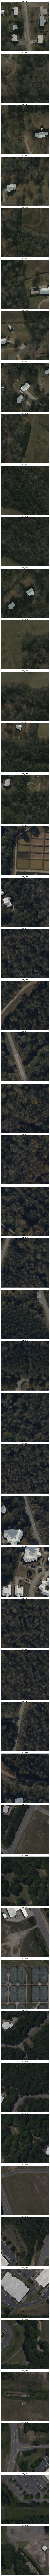

In [30]:
# 인덱스 범위 지정 #짝수만
clear_output()
checker = 14

start_index = 2856 + 50 * checker
end_index = start_index+ 50
# a: 불 투명도 조절 0.0~1.0 기본값 0.4
a = 0.1

samples = []
for i in range(start_index, end_index):
    image, img_id = test_dataset[i]
    samples.append((image, img_id))


fig, axes = plt.subplots(end_index - start_index,1, figsize=(100, 8*(end_index-start_index)))

for i, (image, img_id) in enumerate(samples):
    axes[i].imshow(image)
    for color,c in enumerate(csv_files):
        mask_rle = c.iloc[start_index + i, 1]
        mask = rle_decode(mask_rle, (image.shape[0], image.shape[1]))
        #axes[i].imshow(mask.squeeze(), cmap='hot', alpha=a) # alpha -> 투명도 조절
    
    mask_rle = ensemble_files.iloc[start_index + i,1]
    mask = rle_decode(mask_rle, (image.shape[0], image.shape[1]))
    axes[i].imshow(mask.squeeze(), cmap='hot', alpha=0.4)

    axes[i].set_title(f"{img_id}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()